In [1]:
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from features.transformers import PropertyTypeDropper, CrucialPropertiesMissingDropper, LandSurfaceFixer, ColumnDropper, TerraceSurfaceFixer, MyMinMaxScaler, FacadeImputer, LongitudeLatitudeImputer, LandSurfaceImputer, BathroomCountImputer
from features.build_features import SubtypeOneHotEncoder, OneHotEncodeColumns, CopyColumn
from utils import ImmoFeature as IF

# Load data and plot correlation matrix

In [2]:
df = pd.read_csv("../data/raw/immo-data.csv", low_memory=False)
print(df.shape)
df.head()

(89648, 44)


,ID,Locality,Postal Code,Build Year,Facades,Habitable Surface,Land Surface,Type,Subtype,Price,...,Heating Type,Is Holiday Property,Gas Water Electricity,Sewer,Sea view,Parking count inside,Parking count outside,url,Latitude,Longitude
0,10593948,Knokke-Heist,8300,2023.0,NaN,258.0,NaN,APARTMENT,PENTHOUSE,5995000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.immoweb.be/en/classified/apartment...,NaN,NaN
1,11180831,Uccle,1180,2013.0,4.0,840.0,4425.0,HOUSE,EXCEPTIONAL_PROPERTY,4950000,...,GAS,NaN,True,NaN,NaN,2.0,4.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
2,11188967,Uccle,1180,2013.0,4.0,840.0,4425.0,HOUSE,HOUSE,4950000,...,NaN,NaN,NaN,NaN,NaN,2.0,2.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
3,11050739,Maaseik,3680,2012.0,4.0,330.0,4744.0,HOUSE,VILLA,1150000,...,GAS,NaN,NaN,NaN,NaN,1.0,20.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
4,11201542,Lommel,3920,NaN,4.0,NaN,4000.0,HOUSE,HOUSE,1150000,...,NaN,NaN,True,CONNECTED,NaN,NaN,50.0,https://www.immoweb.be/en/classified/house/for...,51.208163,5.30915


# Drop all but houses and apartments

In [3]:

from features.transformers import BathroomCountImputer
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ("Properties need to be of selected subtypes and of normal sale", PropertyTypeDropper()),
    ("CrucialPropertiesMissingDropper", CrucialPropertiesMissingDropper()),
    ("One Hot Encode Subtypes", SubtypeOneHotEncoder()),
    ("One hot encoder", OneHotEncodeColumns(columns=[IF.kitchen_type.value, IF.state_of_building.value, IF.heating_type.value, IF.epc.value])),
    ("Set Land Surface to 0 for Apartments", LandSurfaceFixer()),
    ("Set Terrace to 0 for NaN", TerraceSurfaceFixer()),
    ("copy the price column", CopyColumn(IF.price.value, f'{IF.price.value}_scaled')),
    ("min max scaler", MyMinMaxScaler(excluded=[IF.price.value])),
    ("Facade imputer", FacadeImputer()), # TODO complete this
    ("longitude, latitude, imputer", LongitudeLatitudeImputer()),
    ("land surface imputer", LandSurfaceImputer()),
    ("bathroom count imputer", BathroomCountImputer()),
    ("Drop Columns with alot of missing values", ColumnDropper()),
    # ("Transform column to 1 or 0", BinaryToFloatTransformer()),
    # normalize all data with min max scaling except for the price
    # impute missing values for Facades, Latitude, Longitude, bathroomcount, land surface
])

In [4]:
df = pipeline.fit_transform(df)
print(df.shape)
df

(73463, 59)


,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,EPC_B,EPC_B_A,EPC_C,EPC_D,EPC_E,EPC_F,EPC_F_E,EPC_G,EPC_nan,Price_scaled
0,5995000,0.811833,NaN,0.002893,0.000000,0.042857,0.086957,0.003817,0.698801,0.233118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.399066
1,4950000,0.020018,2.0,0.009497,0.027529,0.085714,0.173913,0.000000,0.549704,0.499061,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.329329
2,1150000,0.298043,2.0,0.003710,0.029514,0.057143,0.043478,0.000000,0.636619,0.852508,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075742
3,4950000,0.020018,2.0,0.010177,0.017420,0.071429,0.130435,0.000000,0.549704,0.499061,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.329329
4,3950000,0.005560,2.0,0.005979,0.001325,0.071429,0.173913,0.000000,0.567432,0.495299,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.262596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73458,1580000,0.666148,2.0,0.014772,0.808775,0.171429,0.043478,0.000000,0.406358,0.750490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.104438
73459,1580000,0.656139,2.0,0.014772,0.808775,0.171429,0.043478,0.000000,0.399886,0.739838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.104438
73460,1650000,0.650578,2.0,0.009610,0.020437,0.128571,0.086957,0.000000,0.313483,0.678713,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109109
73461,239000,0.629448,2.0,0.001384,0.002426,0.042857,0.000000,0.003053,0.382332,0.846582,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014948


In [5]:
df.describe()

,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,EPC_B,EPC_B_A,EPC_C,EPC_D,EPC_E,EPC_F,EPC_F_E,EPC_G,EPC_nan,Price_scaled
count,7.346300e+04,73463.000000,48452.000000,73463.000000,73463.000000,73463.000000,63743.000000,73463.000000,73463.000000,73463.000000,...,73463.000000,73463.000000,73463.000000,73463.000000,73463.000000,73463.000000,73463.000000,73463.000000,73463.000000,73463.000000
mean,4.321277e+05,0.460854,2.020969,0.001715,0.002892,0.039107,0.012825,0.001590,0.575566,0.482319,...,0.132938,0.000068,0.107265,0.090277,0.062344,0.067925,0.000027,0.040156,0.360072,0.027836
std,4.190710e+05,0.338614,0.203714,0.004012,0.016539,0.018729,0.030169,0.006639,0.085227,0.192608,...,0.339510,0.008250,0.309452,0.286580,0.241781,0.251619,0.005218,0.196327,0.480024,0.027966
min,1.499900e+04,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.675000e+05,0.144573,2.000000,0.001021,0.000000,0.028571,0.000000,0.000000,0.525811,0.345988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016850
50%,3.450000e+05,0.400578,2.000000,0.001407,0.000000,0.042857,0.000000,0.000000,0.577948,0.496691,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022022
75%,4.650000e+05,0.822954,2.000000,0.002008,0.002389,0.042857,0.000000,0.001985,0.641885,0.598864,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.030030
max,1.500000e+07,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# show the percentage of missing values
missing = df.isnull().sum()
missing = missing / df.shape[0] * 100
# show missing where not 0
missing[missing > 0]


Facades           34.04571
Bathroom Count    13.23115
dtype: float64

<Axes: >

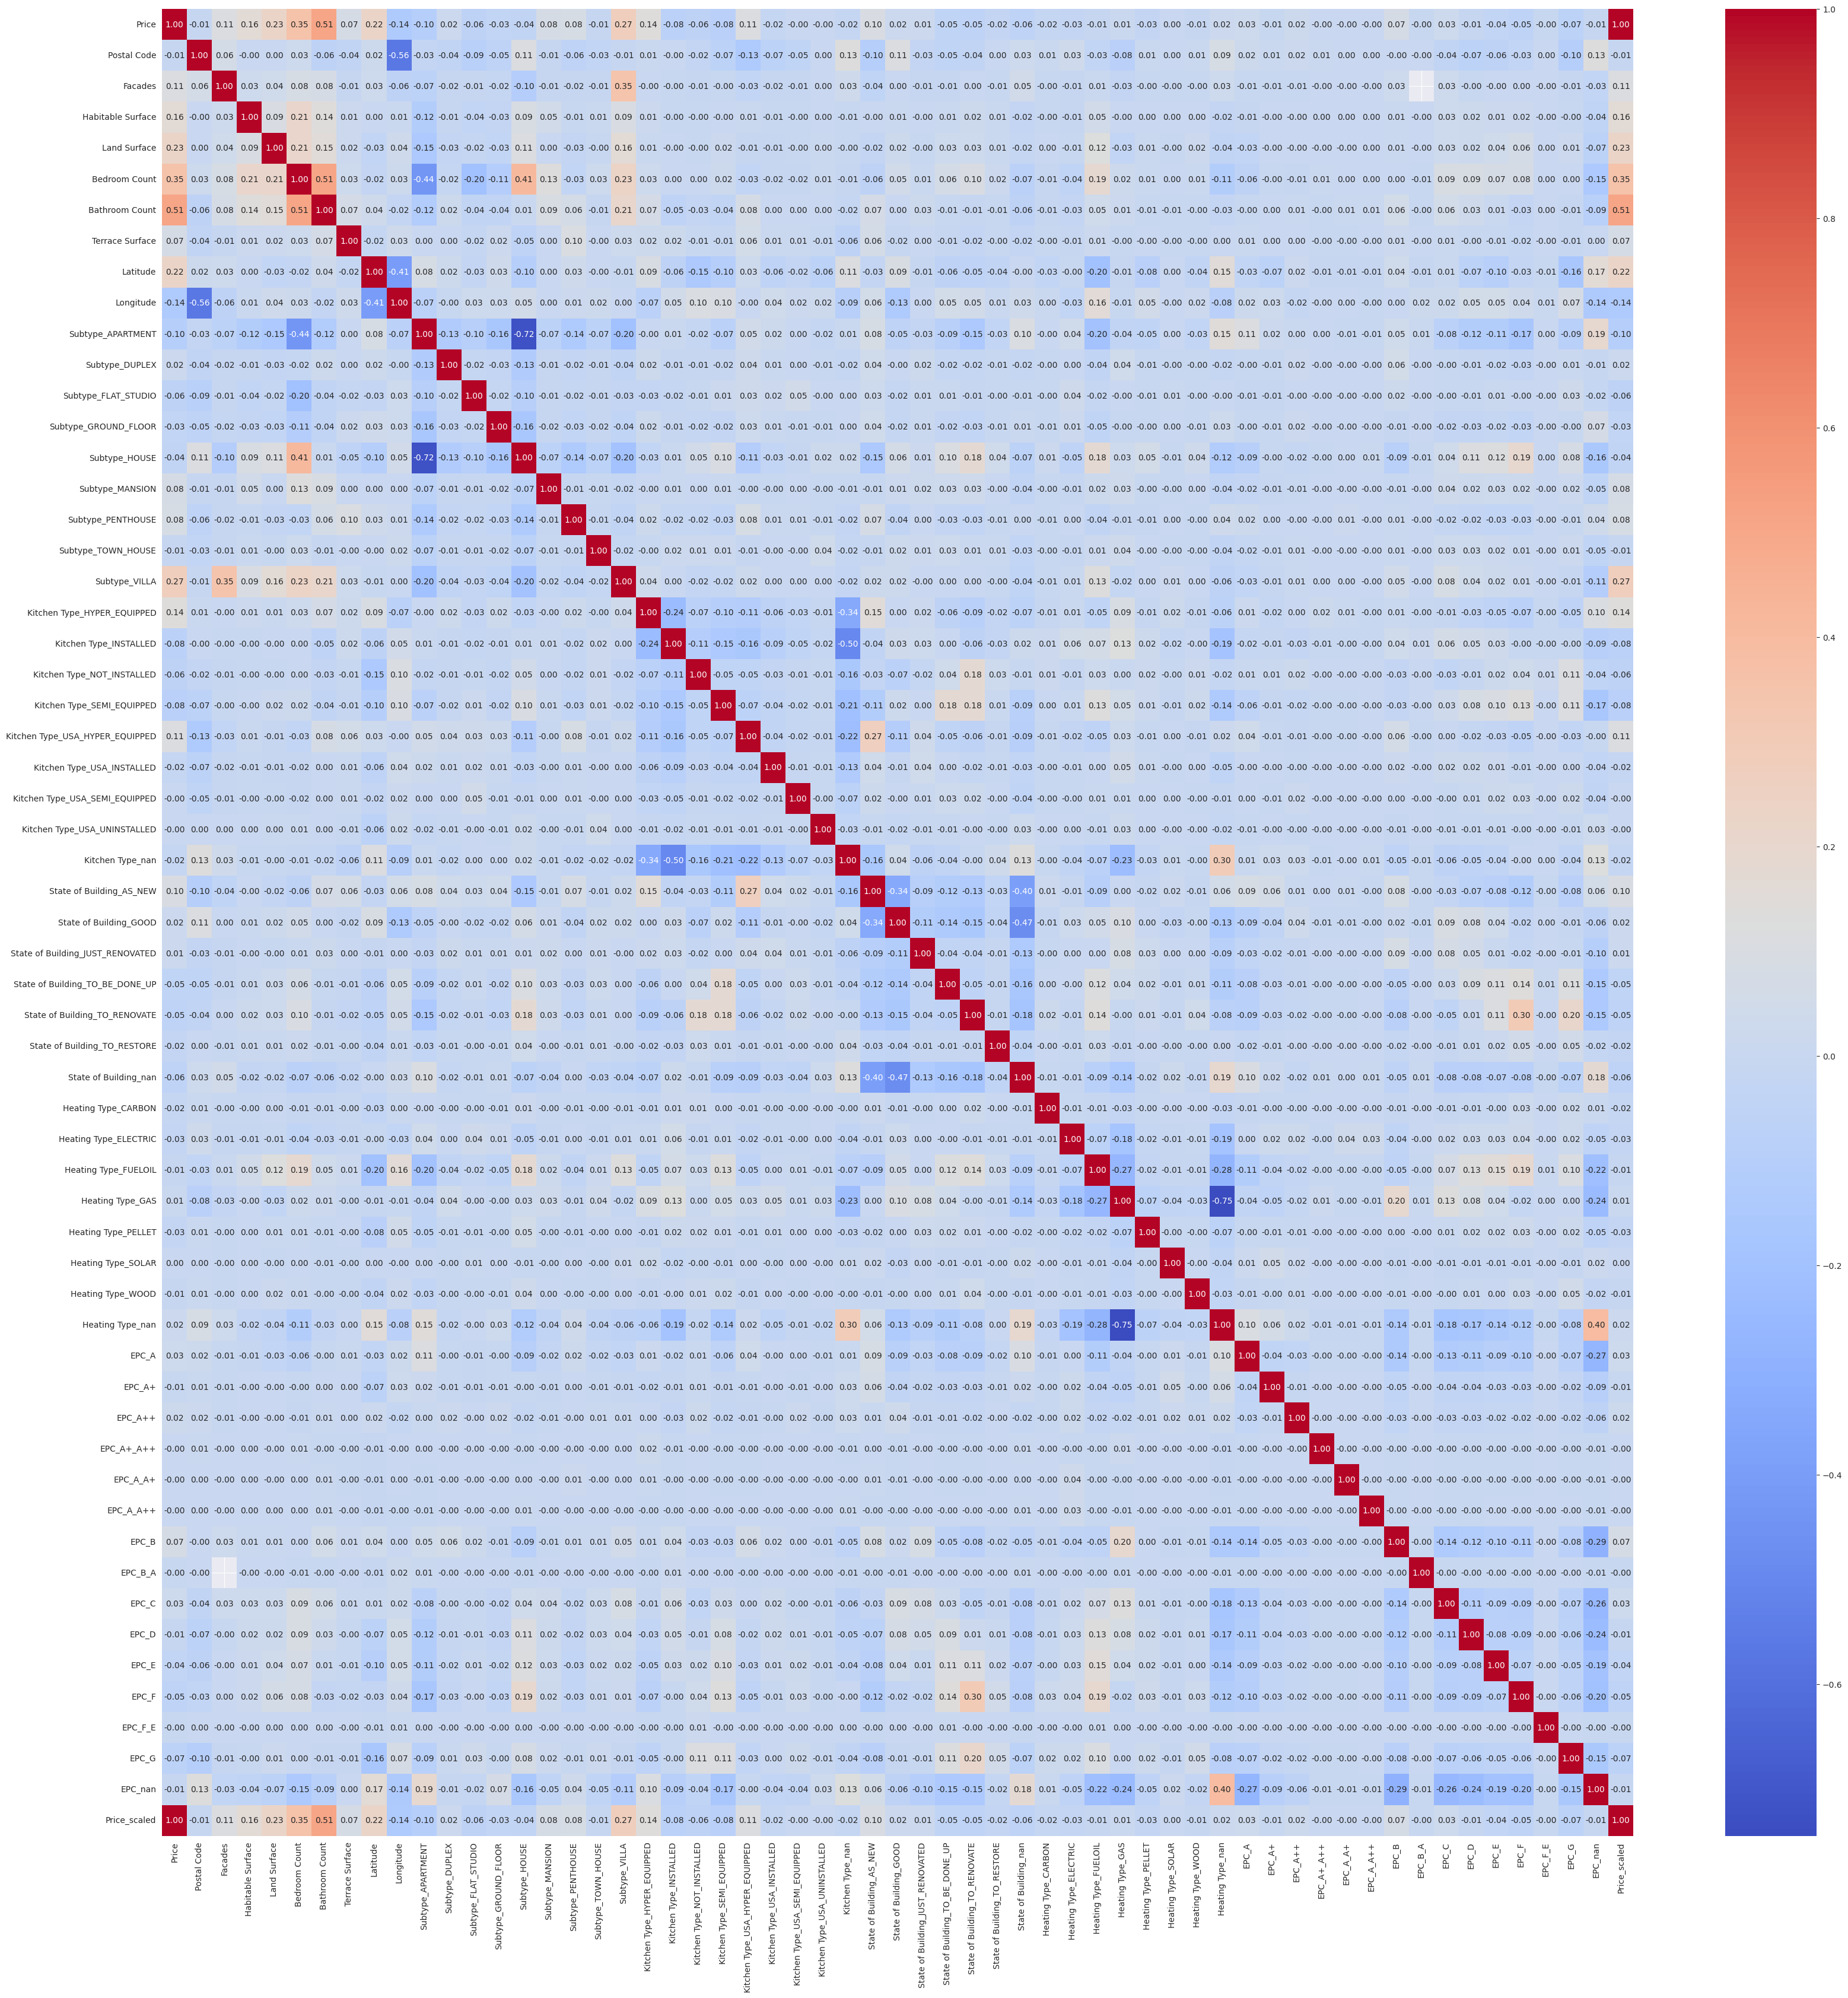

In [12]:
# drop all the columns that are not numeric
df = df.select_dtypes(include=['float64', 'int64'])
# plot correlation matrix with mathplotlib no seaborn


plt.figure(figsize=(40,40))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [8]:
# print all the columns that have a low correlation with the price
corr = df.corr()
corr = corr[IF.price.value]
# make the correlation absolute
corr
# print the columns that have a low correlation with the price

Price                               1.000000
Postal Code                        -0.012594
Facades                             0.112173
Habitable Surface                   0.162181
Land Surface                        0.227967
Bedroom Count                       0.353990
Bathroom Count                      0.513457
Terrace Surface                     0.073044
Latitude                            0.224682
Longitude                          -0.137140
Subtype_APARTMENT                  -0.103517
Subtype_DUPLEX                      0.017750
Subtype_FLAT_STUDIO                -0.058213
Subtype_GROUND_FLOOR               -0.032507
Subtype_HOUSE                      -0.037937
Subtype_MANSION                     0.075575
Subtype_PENTHOUSE                   0.084046
Subtype_TOWN_HOUSE                 -0.010492
Subtype_VILLA                       0.274699
Kitchen Type_HYPER_EQUIPPED         0.139969
Kitchen Type_INSTALLED             -0.075392
Kitchen Type_NOT_INSTALLED         -0.060396
Kitchen Ty

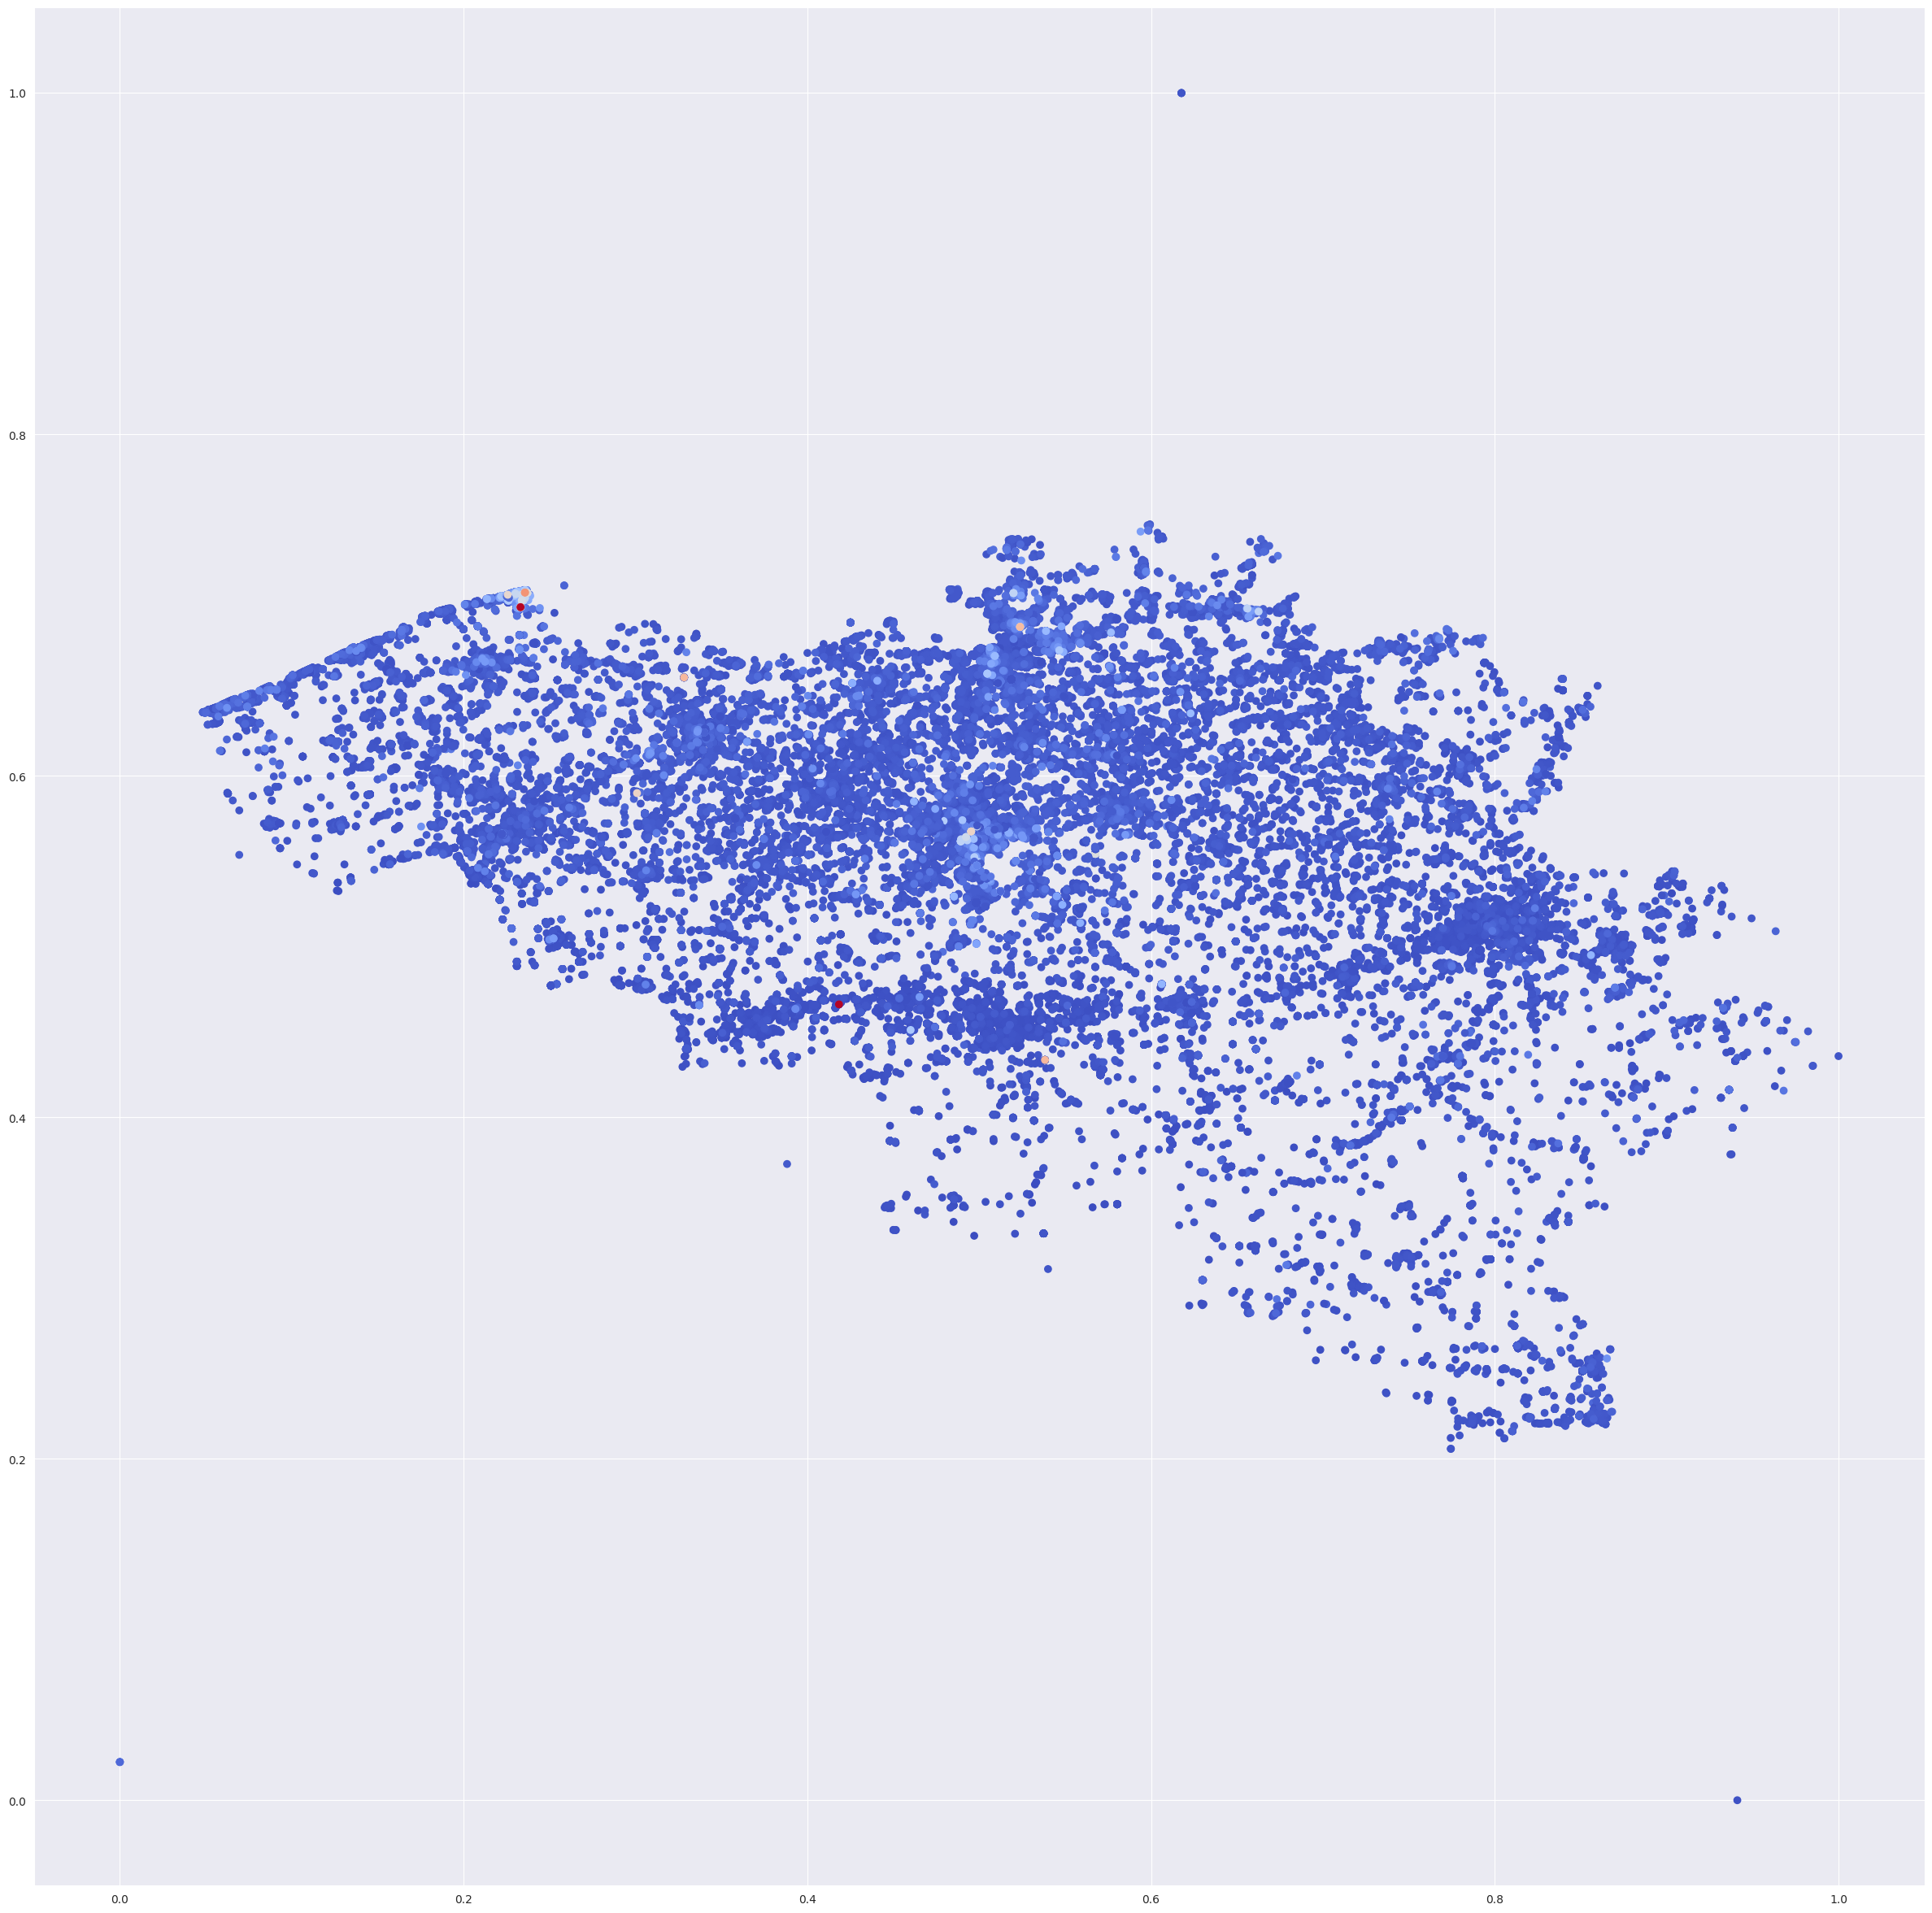

In [9]:
# plot long lat color code price
plt.figure(figsize=(30,30))
none = plt.scatter(df[IF.longitude.value], df[IF.latitude.value], c=df[IF.price.value], cmap='coolwarm')

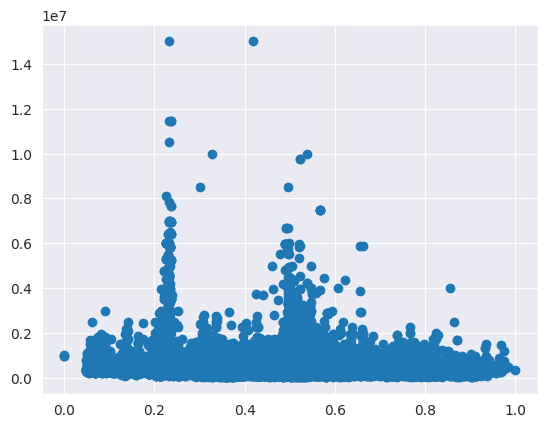

In [10]:
# plot long latitude price
plt.scatter(df["Longitude"], df["Price"])

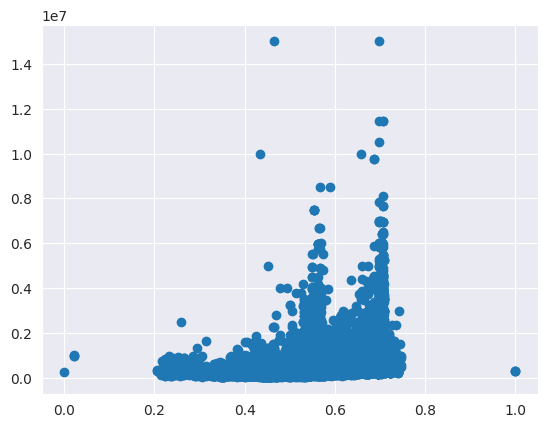

In [11]:
plt.scatter(df["Latitude"], df["Price"])